In [43]:
import pickle
import copy
import numpy as np
import g2o
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
sys.path.append("..")
from mapper.geometry import from_twist, to_twist

np.random.seed(0)

In [44]:
def extract_keypoints(frame, fast, orb, use_ssc=False,
    ssc_num_retain_points=3000, ssc_threshold=0.1):
    """Extracts FAST feature points and ORB descriptors in the frame."""
    kp = fast.detect(frame, None)
    kp = sorted(kp, key = lambda x:x.response, reverse=True)
    kp, des = orb.compute(frame, kp)
    return kp, des


def match(bf, last_keyframe, frame, last_des, des, last_kp, kp, distance_threshold=30.0, draw=True):
    matches = bf.match(last_des, des)
    matches = sorted(matches, key = lambda x:x.distance)
    # filter out matches with distance (descriptor appearance) greater than threshold
    matches = [m for m in matches if m.distance < distance_threshold]
    print("Found {} matches of current frame with last key frame".format(len(matches)))
    last_pts = np.array([last_kp[m.queryIdx].pt for m in matches]).reshape(1, -1, 2)
    current_pts = np.array([kp[m.trainIdx].pt for m in matches]).reshape(1, -1, 2)
    match_frame = np.zeros_like(frame)
    if draw:
        match_frame = cv2.drawMatches(last_keyframe, last_kp, frame, kp, matches, None)
    return matches, last_pts, current_pts, match_frame


def to_celsius(image):
    """Convert raw intensity values of radiometric image to Celsius scale."""
    return image*0.04-273.15


def preprocess_radiometric_frame(frame, equalize_hist=True):
    """Preprocesses raw radiometric frame.

    First, the raw 16-bit radiometric intensity values are converted to Celsius
    scale. Then, the image values are normalized to range [0, 255] and converted
    to 8-bit. Finally, histogram equalization is performed to normalize
    brightness and enhance contrast.
    """
    frame = to_celsius(frame)
    frame = (frame - np.min(frame)) / (np.max(frame) - np.min(frame))
    frame = (frame*255.0).astype(np.uint8)
    if equalize_hist:
        frame = cv2.equalizeHist(frame)
    return frame

In [51]:
img0 = cv2.imread("data_processing/splitted/radiometric/frame_000112.tiff", cv2.IMREAD_ANYDEPTH)
img0 = preprocess_radiometric_frame(img0)

img1 = cv2.imread("data_processing/splitted/radiometric/frame_000138.tiff", cv2.IMREAD_ANYDEPTH)
img1 = preprocess_radiometric_frame(img1)

In [52]:
orb = cv2.ORB_create()
fast = cv2.FastFeatureDetector_create(threshold=12, nonmaxSuppression=True)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

kp0, des0 = extract_keypoints(img0, fast, orb)
kp1, des1 = extract_keypoints(img1, fast, orb)

In [54]:
matches, last_pts, current_pts, match_frame = match(bf, img0, img1, des0, des1, kp0, kp1, 20.0, draw=False)

Found 614 matches of current frame with last key frame


In [89]:
des0[2382].shape

(32,)

In [90]:
matches[0].queryIdx, matches[0].trainIdx

(2382, 2967)

In [91]:
print(des0[matches[0].queryIdx])
print(des1[matches[0].trainIdx])
print(cv2.norm(des0[matches[0].queryIdx], des1[matches[0].trainIdx], cv2.NORM_HAMMING))

[ 14 221  50 135 241  94 182 172  61 236  79   1 204 126  15 196 182 127
 147  99 116 144  89 238  47 119  15   7   2 119 141 215]
[ 14 221  48 135 241  94 182 172  61 236  79   1 204 126  15 196 182 127
 147  99 116 144  89 238  47 119  15   7   2 119 141 215]
1.0


In [123]:
from scipy.spatial.distance import pdist, squareform

def get_representative_orb(descriptors):
    """Returns a representative ORB descriptor in a list of descriptors.
    
    Args:
        descriptors (`list` of `numpy.ndarray`): Each list item is an ORB
            descriptor of dtype uint8 and shape (32,).
    
    Returns:
        representative_orb (`numpy.ndarray`): The representative ORB descriptor 
        which is the one with smallest Hamming distance to all other descriptors 
        in the provided list.
    """
    descriptors = np.vstack(descriptors)
    print(descriptors.shape)
    dist = pdist(descriptors, metric="hamming")
    dist = squareform(dist)
    print(dist)
    print(np.sum(dist, axis=0))
    rep_idx = np.argmin(np.sum(dist, axis=0))
    print(rep_idx)
    representative_orb = descriptors[rep_idx, :]
    return representative_orb

descriptors = [des0[2382], des1[2967], des0[2382] + np.random.randint(-2, 2, size=(32,)), des0[2382] + np.random.randint(-2, 2, size=(32,)), des0[2382] + np.random.randint(-2, 2, size=(32,)), des0[0]]
print(descriptors)
get_representative_orb(descriptors)

[array([ 14, 221,  50, 135, 241,  94, 182, 172,  61, 236,  79,   1, 204,
       126,  15, 196, 182, 127, 147,  99, 116, 144,  89, 238,  47, 119,
        15,   7,   2, 119, 141, 215], dtype=uint8), array([ 14, 221,  48, 135, 241,  94, 182, 172,  61, 236,  79,   1, 204,
       126,  15, 196, 182, 127, 147,  99, 116, 144,  89, 238,  47, 119,
        15,   7,   2, 119, 141, 215], dtype=uint8), array([ 14, 219,  51, 136, 239,  95, 183, 173,  61, 237,  78,   1, 203,
       127,  16, 195, 180, 128, 147,  98, 115, 145,  88, 237,  47, 117,
        13,   6,   0, 118, 139, 213]), array([ 14, 220,  50, 136, 239,  95, 181, 171,  60, 237,  80,   0, 203,
       127,  14, 194, 181, 125, 147, 100, 114, 145,  90, 238,  46, 117,
        13,   5,   2, 118, 142, 216]), array([ 12, 222,  50, 133, 239,  92, 180, 172,  62, 235,  78,  -1, 204,
       125,  14, 197, 180, 128, 148,  97, 116, 145,  88, 236,  47, 119,
        15,   6,   3, 120, 140, 214]), array([197,  48,  29,  97,   1,  78,  96,  56, 104, 184,  

array([ 14, 221,  50, 135, 241,  94, 182, 172,  61, 236,  79,   1, 204,
       126,  15, 196, 182, 127, 147,  99, 116, 144,  89, 238,  47, 119,
        15,   7,   2, 119, 141, 215])

In [29]:
camera_matrix = pickle.load(open("camera_calibration/parameters/ir/camera_matrix.pkl", "rb"))
pose_graph = pickle.load(open("bundle_adjustment_experiments/pose_graph.pkl", "rb"))
map_points = pickle.load(open("bundle_adjustment_experiments/map_points.pkl", "rb"))

In [31]:
des = pose_graph.nodes[0]["des"]

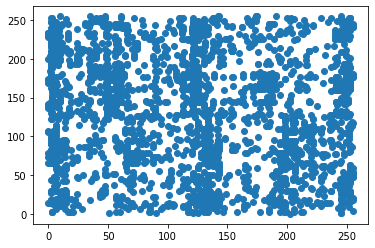

In [37]:
plt.scatter(des[:, 0], des[:, 5])

In [38]:
des

array([[  6,  39,  16, ...,  39,  13, 198],
       [ 14, 103,  16, ...,  55,  15, 134],
       [142,  93,  48, ...,  55,  13, 134],
       ...,
       [204, 241,  60, ...,  35,  15,   3],
       [ 70, 183, 188, ..., 115, 135,  83],
       [ 46, 149, 112, ..., 175, 220, 199]], dtype=uint8)